In [13]:
#from google.colab import drive
#drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [40]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
from datetime import timedelta
import datetime

# Please read, my idea was to classify the data into three cateogries: "UP", "DOWN", "NEUTRAL"
# UP - the price of the stock is up MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# DOWN - the price of the stock is down MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# NEUTRAL - the price of stock is did not rise or fall past the MINIMUM_GAIN threshhold
#
# EXAMPLE: LOOK_AHEAD_DAYS = 30, MINIMUM_GAIN = .05 (5%). If stock is up over 5% ore more after 30 days, 
# we mark it as 'UP'. If the stock is down 5% or more after 30 days, we mark it as 'DOWN'. If the stock
# is neither up nor down 5%, then we mark it as 'NEUTRAL'

# MINIMUM_GAIN = .05 #minimal gain to be considered up or down for classification, UNUSED NOW

LOOK_BACK_DAYS = 30 #number of days into the past we would like to take into account
LOOK_AHEAD_DAYS = 1 #number of days into the future we are trying to predict

class Utilities:

    @staticmethod
    def getData(ticker, start_date, end_date):
        try:
            stock_data = data.DataReader(ticker,
                                         'yahoo',
                                         start_date,
                                         end_date)
            return stock_data
        except RemoteDataError:
            print('No data found for {t}'.format(t=ticker))
#just get the btc price points from the past year
start_date = datetime.datetime.now() - timedelta(365)
end_date = datetime.datetime.now() - timedelta(1)
btc_df = Utilities.getData('BTC-USD', str(start_date.strftime('%Y-%m-%d')), str(end_date.strftime('%Y-%m-%d')))
btc_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-09,11915.655273,11323.898438,11861.556641,11354.024414,1.812536e+10,11354.024414
2019-08-10,11523.579102,11248.294922,11349.740234,11523.579102,1.577437e+10,11523.579102
2019-08-11,11528.189453,11320.951172,11528.189453,11382.616211,1.364720e+10,11382.616211
2019-08-12,11420.049805,10830.327148,11385.052734,10895.830078,1.668150e+10,10895.830078
2019-08-13,10889.556641,10028.135742,10889.487305,10051.704102,1.999084e+10,10051.704102
...,...,...,...,...,...,...
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461
2020-08-05,11902.335938,11598.713867,11749.871094,11779.773438,2.340074e+10,11779.773438
2020-08-06,11898.038086,11408.593750,11778.894531,11601.472656,2.313231e+10,11601.472656


In [41]:
def createLookBackCols():
    for i in range(LOOK_BACK_DAYS):
        num_rows= btc_df.shape[0]
        num_cols= btc_df.shape[1]
        btc_df.insert(loc = num_cols, column = 'High_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Low_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Open_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Volume_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Adj Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        
createLookBackCols() #create additional look back columns
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
    if (current_date - start_date).days >= LOOK_BACK_DAYS - 1:
        for i in range(LOOK_BACK_DAYS):
            index = i + 1
            look_back_date = current_date - timedelta(days=index)
            
            while True: #we need to keep subtracting days to the look_back_date because there is no index for that day
                if look_back_date in btc_df.index:
                    break
                look_back_date = look_back_date - timedelta(days=1)
            
            btc_df.at[pd.Timestamp(current_date), 'High_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'High']
            btc_df.at[pd.Timestamp(current_date), 'Low_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Low']
            btc_df.at[pd.Timestamp(current_date), 'Open_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Open']
            btc_df.at[pd.Timestamp(current_date), 'Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Close']
            btc_df.at[pd.Timestamp(current_date), 'Volume_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Volume']
            btc_df.at[pd.Timestamp(current_date), 'Adj Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Adj Close']

btc_df = btc_df[btc_df.High_Past_1 != 'N/A']
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Close_Past_29,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-09,10394.353516,10020.573242,10336.408203,10115.975586,1.490681e+10,10115.975586,10335,1.75959e+10,10335,10443.2,...,11382.6,11528.2,11321,11528.2,11523.6,1.57744e+10,11523.6,11349.7,11248.3,11523.6
2019-09-10,10215.948242,9980.776367,10123.035156,10178.372070,1.542806e+10,10178.372070,10116,1.49068e+10,10116,10336.4,...,10895.8,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2
2019-09-11,10442.253906,10099.242188,10176.819336,10410.126953,1.532356e+10,10410.126953,10178.4,1.54281e+10,10178.4,10123,...,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420
2019-09-12,10441.489258,10226.596680,10415.362305,10360.546875,1.410986e+10,10360.546875,10410.1,1.53236e+10,10410.1,10176.8,...,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6
2019-09-13,10422.133789,10291.694336,10345.403320,10358.048828,1.346871e+10,10358.048828,10360.5,1.41099e+10,10360.5,10415.4,...,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461,11246.3,2.02717e+10,11246.3,11043.8,...,9252.28,9349.16,9201.82,9360.62,9375.47,1.78893e+10,9375.47,9072.85,9058.66,9375.47
2020-08-05,11902.335938,11598.713867,11749.871094,11779.773438,2.340074e+10,11779.773438,11747,2.44113e+10,11747,11203.8,...,9428.33,9253.02,9249.5,9450.34,9252.28,1.38397e+10,9252.28,9349.16,9201.82,9360.62
2020-08-06,11898.038086,11408.593750,11778.894531,11601.472656,2.313231e+10,11601.472656,11779.8,2.34007e+10,11779.8,11749.9,...,9277.97,9427.99,9235,9431.38,9428.33,1.97024e+10,9428.33,9253.02,9249.5,9450.34


In [50]:
btc_df = btc_df.assign(MonthTrend=lambda x: "N/A") #introduce new column that will be the trend we are predicting
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

#Populate the classification column MonthTrend
for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
   
    if (end_date - current_date).days > LOOK_AHEAD_DAYS:
        look_ahead_date = current_date + timedelta(days=LOOK_AHEAD_DAYS)
        
        while True: #we need to keep adding days to the look_ahead_date because there is no index for that day
            if look_ahead_date in btc_df.index:
                break
            look_ahead_date = look_ahead_date + timedelta(days=1)
        
        #Here we check if the open price in the future is higher than today's open price.
        if btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] > btc_df.loc[index]['Open']:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'UP'
        else:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'DOWN'
            
#Now delete all columns that have a MonthTrend value of N/A
btc_df = btc_df[btc_df.MonthTrend != 'N/A']

#Data is now fully processed and ready to be trained on the machine learning model
#There are 3 values for MonthTrend: UP, DOWN,NEUTRAL
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-13,10422.133789,10291.694336,10345.403320,10358.048828,1.346871e+10,10358.048828,10360.5,1.41099e+10,10360.5,10415.4,...,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,DOWN
2019-09-14,10387.035156,10313.092773,10356.465820,10347.712891,1.204343e+10,10347.712891,10358,1.34687e+10,10358,10345.4,...,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,UP
2019-09-15,10386.867188,10189.744141,10347.222656,10276.793945,1.516017e+10,10276.793945,10347.7,1.20434e+10,10347.7,10356.5,...,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,DOWN
2019-09-16,10296.771484,10199.739258,10281.513672,10241.272461,1.530460e+10,10241.272461,10276.8,1.51602e+10,10276.8,10347.2,...,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1,DOWN
2019-09-17,10275.928711,10191.469727,10247.795898,10198.248047,1.616927e+10,10198.248047,10241.3,1.53046e+10,10241.3,10281.5,...,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-02,11453.079102,11012.415039,11043.768555,11246.348633,2.027171e+10,11246.348633,11053.6,2.74101e+10,11053.6,11758.8,...,9126.09,8977.02,9162.18,9132.49,1.22905e+10,9132.49,9084.23,9053.63,9183.3,DOWN
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461,11246.3,2.02717e+10,11246.3,11043.8,...,9349.16,9201.82,9360.62,9375.47,1.78893e+10,9375.47,9072.85,9058.66,9375.47,UP
2020-08-05,11902.335938,11598.713867,11749.871094,11779.773438,2.340074e+10,11779.773438,11747,2.44113e+10,11747,11203.8,...,9253.02,9249.5,9450.34,9252.28,1.38397e+10,9252.28,9349.16,9201.82,9360.62,UP


In [52]:
def generateFeatures(features):
    complete_features = []
    for feature in features:
        complete_features.append(feature)
        for i in range(LOOK_BACK_DAYS):
            complete_features.append(feature + "_Past_" + str(i + 1))
    return complete_features

features = generateFeatures(['Close','Open'])
features.append('MonthTrend')

# selecting the important feature open close
btc = btc_df[features]
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-13,10358.048828,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,...,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,DOWN
2019-09-14,10347.712891,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,...,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,UP
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,...,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN
2019-09-16,10241.272461,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,...,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,DOWN
2019-09-17,10198.248047,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,...,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-02,11246.348633,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,9905.17,9677.11,...,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,9072.85,9126.09,9084.23,DOWN
2020-08-04,11747.022461,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,...,9238.7,9277.21,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,9072.85,UP
2020-08-05,11779.773438,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,...,9241.9,9238.7,9277.21,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,UP


In [28]:
# load pre-fetched news sentiment data and add in the dataframe
'''import pickle
import warnings
import os
warnings.filterwarnings('ignore')
f = open(os.path.join(os.getcwd(), "polaritys_score.pkl"), "rb")
#f = open("./drive/My Drive/final_project/polaritys_score.pkl", "rb")
polaritys_file = pickle.load(f)
f.close()

polaritys_df = pd.DataFrame(index=list(polaritys_file.keys())[::-1], columns=['neg', 'neu', 'pos'])
for date in list(polaritys_file.keys())[::-1]:
  for polar in ['neg', 'neu', 'pos']:
    polaritys_df.loc[date][polar] = polaritys_file[date][polar]

## keep data only after 2019-09-09 and remove data on 2020-08-03(error in Yahoo?)
btc_index_str = [btc_index.strftime('%Y-%m-%d') for btc_index in list(btc.index)]

sentiment_data = polaritys_df.loc[btc_index_str]
sentiment_data.columns = ['negative', 'neutral', 'positive']

## add sentiment in the dataframe
btc[['negative', 'neutral', 'positive']] = sentiment_data[['negative', 'neutral', 'positive']]
btc'''

UnpicklingError: invalid load key, '\x0a'.

In [145]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
Y = btc['MonthTrend']
le =LabelEncoder()
Y = le.fit_transform(Y)
X = btc.drop(['MonthTrend'], axis=1)
X = StandardScaler().fit_transform(X)
# Create training and testing datasets that are appropriate for time series data
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=2)
train_size_perc = 0.7
n_time, n_features = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[(train_size+LOOK_AHEAD_DAYS):], Y[(train_size+LOOK_AHEAD_DAYS):]

In [146]:
# decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=45)
param_grid = {'splitter': ["best","random"],  
              'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
             'max_leaf_nodes':[10,50,None]}  
grid =  GridSearchCV(model_tree,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
grid.fit(X_train,Y_train)
tree_error_rate = 1 - grid.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 5760 out of 5760 | elapsed:    2.1s finished


0.5133505598621878

In [147]:
grid.score(X_train, Y_train)

0.8846387370977535

In [148]:
#confusion matrix and classification for testing
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc
import matplotlib.pylab as plt
prediction = grid.predict(X_test)
print(confusion_matrix(Y_test, prediction))

[[30 13]
 [42 12]]


In [149]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.42      0.70      0.52        43
           1       0.48      0.22      0.30        54

    accuracy                           0.43        97
   macro avg       0.45      0.46      0.41        97
weighted avg       0.45      0.43      0.40        97



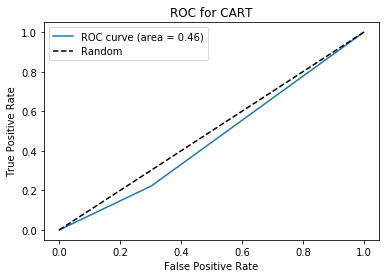

In [150]:
# Plot the ROC curve

def plot_roc(Y_test,Y_pred):
    fpr, tpr, _ = roc_curve(Y_test,Y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC for CART")
    plt.legend(loc="best")
    plt.show()
plot_roc(Y_test,prediction)

In [158]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model_random = RandomForestClassifier(random_state=42)
param_grid = {
             'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
              'min_samples_leaf':[1,2,4,6],
             'max_leaf_nodes':[10,50]}  
random_grid =  GridSearchCV(model_random,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
random_grid.fit(X_train,Y_train)
tree_error_rate =1 - random_grid.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 2420 tasks      | elapsed:    6.6s
[Parallel(n_jobs=6)]: Done 6420 tasks      | elapsed:   18.7s
[Parallel(n_jobs=6)]: Done 7680 out of 7680 | elapsed:   22.5s finished


0.38092161929371227

In [160]:
random_grid.score(X_train, Y_train)

0.8260869565217391

In [162]:
new_prediction = random_grid.predict(X_test)
print(confusion_matrix(Y_test, new_prediction))

[[35  8]
 [36 18]]


In [163]:
print(classification_report(Y_test, new_prediction))

              precision    recall  f1-score   support

           0       0.49      0.81      0.61        43
           1       0.69      0.33      0.45        54

    accuracy                           0.55        97
   macro avg       0.59      0.57      0.53        97
weighted avg       0.60      0.55      0.52        97



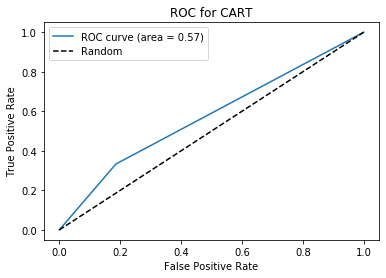

In [164]:
plot_roc(Y_test,new_prediction)

In [168]:
# linear svm
from sklearn.svm import LinearSVC
model_svm = LinearSVC(random_state=42)
param_grid = {
             'C': [1,2,4,6,8,10],
             'loss':["hinge","squared_hinge"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None]}  
svm_grid =  GridSearchCV(model_svm,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
svm_grid.fit(X_train,Y_train)
svm_error_rate =1 - random_grid.score(X_test,Y_test)
svm_error_rate

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 480 out of 480 | elapsed:    2.1s finished


0.38092161929371227

In [169]:
svm_grid.score(X_train, Y_train)

0.9996205221615058

In [170]:
svm_prediction = svm_grid.predict(X_test)
print(confusion_matrix(Y_test, svm_prediction))

[[40  3]
 [ 6 48]]


In [171]:
print(classification_report(Y_test, svm_prediction))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        43
           1       0.94      0.89      0.91        54

    accuracy                           0.91        97
   macro avg       0.91      0.91      0.91        97
weighted avg       0.91      0.91      0.91        97



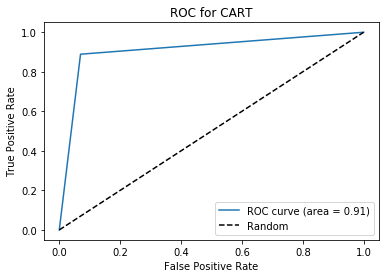

In [172]:
plot_roc(Y_test,svm_prediction)

In [176]:
# logistic regression
from sklearn.linear_model import LogisticRegression
model_regression = LogisticRegression()
param_grid = {
             'C': [1,2,4,6,8,10],
             'penalty':["l1", "l2"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None],
              'warm_start':[True,False]}  
regression_grid =  GridSearchCV(model_regression,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
regression_grid.fit(X_train,Y_train)
regression_error_rate =1 - regression_grid.score(X_test,Y_test)
regression_error_rate

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  41 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 960 out of 960 | elapsed:    4.7s finished


0.003875968992248069

In [177]:
regression_prediction = svm_grid.predict(X_test)
print(confusion_matrix(Y_test, regression_prediction))

[[40  3]
 [ 6 48]]


In [179]:
print(classification_report(Y_test, regression_prediction))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        43
           1       0.94      0.89      0.91        54

    accuracy                           0.91        97
   macro avg       0.91      0.91      0.91        97
weighted avg       0.91      0.91      0.91        97



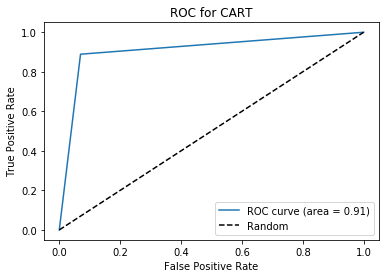

In [178]:
plot_roc(Y_test,regression_prediction)

In [182]:
# install tensorflow in virtual enviroment locally or use google colab
# Please read this line at least.Basic model frame tuning may needed. I reached 0.7347 test accuracy for old dataset.
import tensorflow as tf
# Nerual network layer by layer. The input shape(...,62) may vary if new added
NN_model = tf.keras.models.Sequential()
NN_model.add(tf.keras.layers.Dense(units=128,activation="relu",input_dim=62)) 
# dropout exist for preventing overfitting. 
NN_model.add(tf.keras.layers.Dropout(0.2))
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu"))
NN_model.add(tf.keras.layers.Dropout(0.2)) 
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu")) 
# please do not change this line. sigmoid function is a must for binary classification
NN_model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
# you can play with this line
NN_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy']) 

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [ ]:
# a basic summary of model
NN_model.summary()

In [ ]:
# I added early stop here.
earlyStopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
NN_model.fit(x=X_train,y=Y_train,batch_size=30,epochs=50,callbacks=[earlyStopping])

In [ ]:
test_loss, test_accuracy = NN_model.evaluate(X_test, Y_test)

In [ ]:
NN_prediction = NN_model.predict_classes(X_test)
print(confusion_matrix(Y_test,NN_prediction))

In [ ]:
print(classification_report(Y_test,NN_prediction))

In [ ]:
plot_roc(Y_test,NN_prediction)